In [1]:
import rosbag
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tf
from scipy.signal import find_peaks

In [2]:

bag = rosbag.Bag('/home/uware/rosbags/static/translation/16h5_s_z_2-4-6-8-10_720_30.bag')

# create variables
target = 'distance - z'
true_value = 'true_distance'

# input values in meters. the order matters, it will be used for binning 
input_vals = [2,4,6,8,10]

In [3]:
topic = '/tf'

rows = []

for topic, msg, t in bag.read_messages(topics=topic):
    
    time = t
    distance = msg.transforms[0].transform.translation.z

    # print(msg.transforms[0].header.stamp.secs, msg.transforms[0].header.stamp.nsecs)
    
    # create row
    row={'time': time.to_sec(), target: distance}
    rows.append(row)

df = pd.DataFrame.from_records(rows)

In [4]:
# calculate relative time in seconds instead of absolute time
df['relative_time'] =  df.loc[0:, 'time'] - df.at[0, 'time']
df = df.drop(columns=['time'])
df = df[['relative_time', target]]
df

,relative_time,distance - z
0,0.000000,8.782432
1,0.521732,2.607496
2,2.643071,12.019321
3,2.998963,4.597394
4,8.204559,2.089604
...,...,...
1030,113.340234,12.615003
1031,115.551266,8.821924
1032,116.892225,5.399960
1033,118.157073,2.410818


<AxesSubplot:xlabel='relative_time'>

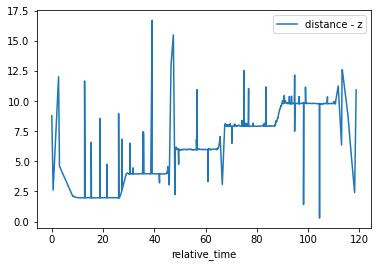

In [5]:
# initial graph
df.plot(x='relative_time', y=target)

In [6]:
# find plateaus
x = df[target]
peaks, _ = find_peaks(x, threshold=(0, 1)) # from find_peaks docs: Threshold: The first element is always interpreted as the minimal and the second, if supplied, as the maximal required threshold.

In [7]:
# the amount of data points we are left with
len(x[peaks])

245

In [8]:
# create filtered data frame
df_filtered_by_targets = df.loc[peaks]

<AxesSubplot:xlabel='relative_time', ylabel='distance - z'>

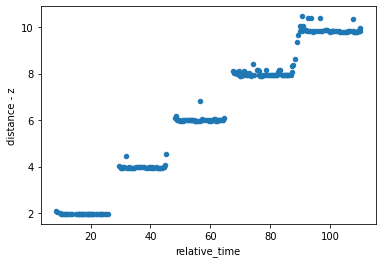

In [9]:
df_filtered_by_targets.plot.scatter(x='relative_time', y=target)

In [10]:
# segmenting/binning by real value
df_filtered_by_targets[true_value] = pd.cut(df_filtered_by_targets[target], bins=len(input_vals), labels=input_vals)
df_filtered_by_targets

,relative_time,distance - z,true_distance
7,8.477296,2.110332,2
10,8.755544,2.077099,2
21,9.731023,2.006619,2
25,10.095030,1.988969,2
29,10.445126,1.981787,2
...,...,...,...
1011,108.985179,9.802371,10
1013,109.177752,9.814204,10
1019,109.746957,9.845841,10
1021,109.942837,9.820824,10


In [11]:
# calculate the error
df_filtered_by_targets['error'] =  df_filtered_by_targets.apply(lambda row: row[true_value] - row[target], axis=1)

In [12]:
grouped_df = df_filtered_by_targets.groupby(true_value)

In [13]:
# verify if the bins are in correct order, this is dictated by input_vals order
grouped_df.tail(3)

,relative_time,distance - z,true_distance,error
183,24.752275,1.975847,2,0.024153
188,25.199072,1.976624,2,0.023376
194,25.806198,1.973280,2,0.026720
386,44.584923,3.969006,4,0.030994
390,44.951296,4.092125,4,-0.092125
393,45.234172,4.559036,4,-0.559036
567,63.897462,6.009624,6,-0.009624
572,64.375583,6.012756,6,-0.012756
575,64.640133,6.091696,6,-0.091696
785,87.338173,8.311477,8,-0.311477


In [14]:
grouped_df.error.describe()

,count,mean,std,min,25%,50%,75%,max
true_distance,,,,,,,,
2,44.0,0.015250,0.025035,-0.110332,0.016550,0.020602,0.024768,0.029044
4,41.0,0.002620,0.120281,-0.559036,0.026088,0.032835,0.039415,0.046786
6,49.0,-0.020784,0.124374,-0.835652,-0.010958,0.001634,0.016500,0.043909
8,58.0,-0.010784,0.142404,-0.626787,-0.052157,0.059809,0.074575,0.106280
10,53.0,0.131003,0.192645,-0.455169,0.154159,0.185599,0.199245,0.647204


In [15]:
def box_plotter(column_name):
    fig, axes = plt.subplots(1,len(input_vals))

    for i, val in enumerate(input_vals):
        grouped_df.get_group(val).boxplot(column=column_name, ax=axes.flatten()[i])
        axes.flatten()[i].set_title(val)


    plt.tight_layout()
    plt.show()

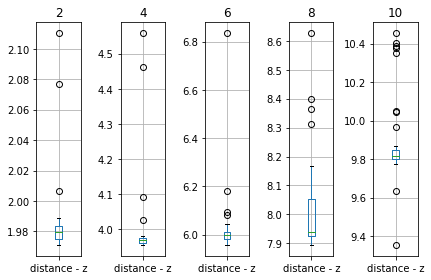

In [16]:
box_plotter(target)

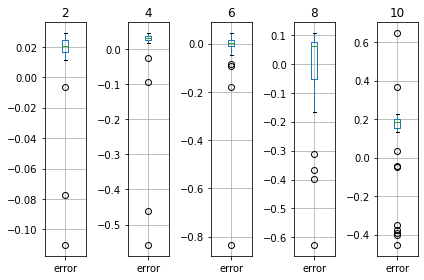

In [17]:
box_plotter('error')